# EfficientNet

In [1]:
# !pip install tensorflow-gpu==2.9

In [2]:
# !pip install opencv-python==4.5.1.48
# !pip install pandas==1.2.1
# !pip install Pillow==8.1.0
# !pip install pydicom==2.1.2
# !pip install scikit-learn==0.24.1
# !pip install scipy==1.6.0
# !pip install tqdm==4.56.0
# !pip install tikzplotlib
# !pip install efficientnet
# !pip install seaborn 

In [3]:
import os
import cv2
import pydicom
import tikzplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import efficientnet.tfkeras as efn

In [4]:
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.backend as K
from tqdm.notebook import tqdm
from tensorflow.keras import Model
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, GaussianNoise, 
    Add, Conv2D, AveragePooling2D, LeakyReLU, Concatenate 
)

# Load and Transform Data

In [5]:
train = pd.read_csv('./Dataset/train.csv')

In [6]:
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [7]:
train['Percent'].max()

153.145377828922

In [8]:
train['Percent'].min()

28.8775766716943

In [9]:
train.SmokingStatus.unique()

array(['Ex-smoker', 'Never smoked', 'Currently smokes'], dtype=object)

In [10]:
def get_tab(df):
    " return an array which contains each patient normalized age, sex and smoking status"
    vector = [(df.Age.values[0] - 30) / 30] 
    
    if df.Sex.values[0].lower() == 'male':
       vector.append(0)
    else:
       vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector)

In [11]:
A = {} 
TAB = {} 
P = [] 
for i, p in tqdm(enumerate(train.Patient.unique())): # i index, p patient id
    sub = train.loc[train.Patient == p, :] # find all data (weeks, FVC, Percent, Age, Sex, SmokingStatus) of a unique patient
    fvc = sub.FVC.values # fvc values of the patient during the follow-up
    weeks = sub.Weeks.values # follow-up weeks
    c = np.vstack([weeks, np.ones(len(weeks))]).T # create an array by the follow-up weeks of shape(len(weeks),2)
    a, b = np.linalg.lstsq(c, fvc)[0] # least-square sol, a=gradient matrix, b=right hand matrix 
    
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

0it [00:00, ?it/s]

C:\Users\user\Anaconda3\envs\keras-gpu\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == "__main__":


In [12]:
def get_img(path):
    " read DICOM dataset and return resize images of size (512,512,3)"
    d = pydicom.dcmread(path) # read and parse the CT scan images (in DICOM format)
    resized_image = cv2.resize((d.pixel_array - d.RescaleIntercept) / (d.RescaleSlope * 1000), (512,512))
    resized_image = np.stack((resized_image,)*3, axis = -1)
    return resized_image

In [13]:


class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size):
        "key=patient, a=gradient matrix, tab=a particular patient's data"
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'./Dataset//train/{p}/')
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size) # randomly chooses n=batch_size number of patients
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0] # chooses some randomly images for kth patient
                img = get_img(f'./Dataset//train/{k}/{i}') # resizes ith image of kth patient
                x.append(img) # append kth patient's image data in the list x
                a.append(self.a[k]) # append kth patient's gradinet in the list a
                tab.append(self.tab[k]) # append kth patient's tabular data in the tab list
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab) # convert list to array
        #x = np.expand_dims(x, axis=-1) 
        return [x, tab] , a

## Build the Model

In [14]:
def get_model(model, shape):
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights='imagenet',include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False),
        'b2': efn.EfficientNetB2(input_shape=shape,weights='imagenet',include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False),
        #'RNet50': resnet50.ResNet50(input_shape=shape,weights=None,include_top=False),
        #'V16': vgg16.VGG16(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(512, 512, 3), model_class=None):
    inp = Input(shape=shape)
    base = get_model(model_class, shape)
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    inp2 = Input(shape=(4,)) # indicates that the expected input will be batches of 4-dimensional vectors
    x2 = GaussianNoise(0.2)(inp2) # to mitigate overfitting
    x = Concatenate()([x, x2]) 
    x = Dropout(0.5)(x) 
    x = Dense(1)(x)
    model = Model([inp, inp2] , x)
    return model

In [15]:
MODEL_CLASS = 'b2'
base_model = build_model(shape=(512, 512, 3), model_class=MODEL_CLASS)
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnet-b2 (Functional)   (None, 16, 16, 1408  7768562     ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 input_10 (InputLayer)          [(None, 4)]          0           []                               
                                                                                              

## Compile and Train the Model

In [16]:
BATCH_SIZE = 4
EPOCHS = 100
LR = 0.001
SAVE_BEST = True
tr_p, vl_p = train_test_split(P, shuffle=True, train_size= 0.8) 

In [17]:
P = np.array(P)
subs = []
folds_history = []

"""
er = tf.keras.callbacks.EarlyStopping(monitor="val_loss",min_delta=1e-3,patience=15,verbose=1,mode="auto",baseline=None,
      restore_best_weights=True,) #Stop training when a monitored metric has stopped improving.
"""

cpt = tf.keras.callbacks.ModelCheckpoint(filepath=f'{MODEL_CLASS}_{EPOCHS}_epochs.h5',monitor='val_loss',verbose=1, 
    save_best_only=SAVE_BEST,mode='auto') #to save model or weights in a checkpoint file at lowest validation loss

rlp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5, verbose=1, min_lr=1e-8) 
     #Reduce learning rate when a metric has stopped improving.
     # if improvement stops, after 5 epochs learning rate will be reduced

model = build_model(model_class=MODEL_CLASS)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss="mae") 
history = model.fit(IGenerator(keys=tr_p, a = A, tab = TAB, batch_size=BATCH_SIZE), 
                    steps_per_epoch = 32,
                    validation_data=IGenerator(keys=P, a = A, tab = TAB, batch_size=BATCH_SIZE),
                    validation_steps = 32, 
                    callbacks = [cpt, rlp], 
                    epochs=EPOCHS)
folds_history.append(history.history)
print('Training Complete!!!')

Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 4.5192
Epoch 1: val_loss improved from inf to 4.69261, saving model to b2_100_epochs.h5
32/32 [==============================] - 110s 3s/step - loss: 4.5192 - val_loss: 4.6926 - lr: 0.0010
Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 4.2103
Epoch 2: val_loss did not improve from 4.69261
32/32 [==============================] - 89s 3s/step - loss: 4.2103 - val_loss: 4.7207 - lr: 0.0010
Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 4.7008
Epoch 3: val_loss did not improve from 4.69261
32/32 [==============================] - 90s 3s/step - loss: 4.7008 - val_loss: 8.7046 - lr: 0.0010
Epoch 4/100
32/32 [==============================] - ETA: 0s - loss: 4.3147
Epoch 4: val_loss did not improve from 4.69261
32/32 [==============================] - 89s 3s/step - loss: 4.3147 - val_loss: 8.2120 - lr: 0.0010
Epoch 5/100
32/32 [==============================] - ETA: 0s - loss: 4.94

Epoch 35/100
32/32 [==============================] - ETA: 0s - loss: 4.4041
Epoch 35: val_loss did not improve from 3.76268
32/32 [==============================] - 88s 3s/step - loss: 4.4041 - val_loss: 4.0746 - lr: 6.2500e-05
Epoch 36/100
32/32 [==============================] - ETA: 0s - loss: 4.8901
Epoch 36: val_loss did not improve from 3.76268
32/32 [==============================] - 88s 3s/step - loss: 4.8901 - val_loss: 4.2018 - lr: 6.2500e-05
Epoch 37/100
32/32 [==============================] - ETA: 0s - loss: 4.0576
Epoch 37: val_loss did not improve from 3.76268
32/32 [==============================] - 88s 3s/step - loss: 4.0576 - val_loss: 3.9756 - lr: 6.2500e-05
Epoch 38/100
32/32 [==============================] - ETA: 0s - loss: 4.3062
Epoch 38: val_loss did not improve from 3.76268
32/32 [==============================] - 88s 3s/step - loss: 4.3062 - val_loss: 3.9499 - lr: 6.2500e-05
Epoch 39/100
32/32 [==============================] - ETA: 0s - loss: 3.8936
Epoch 3

Epoch 69/100
32/32 [==============================] - ETA: 0s - loss: 4.0898
Epoch 69: val_loss did not improve from 2.84388
32/32 [==============================] - 88s 3s/step - loss: 4.0898 - val_loss: 3.4774 - lr: 1.9531e-06
Epoch 70/100
32/32 [==============================] - ETA: 0s - loss: 4.1448
Epoch 70: val_loss did not improve from 2.84388

Epoch 70: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
32/32 [==============================] - 88s 3s/step - loss: 4.1448 - val_loss: 3.6296 - lr: 1.9531e-06
Epoch 71/100
32/32 [==============================] - ETA: 0s - loss: 3.0505
Epoch 71: val_loss did not improve from 2.84388
32/32 [==============================] - 89s 3s/step - loss: 3.0505 - val_loss: 3.3308 - lr: 9.7656e-07
Epoch 72/100
32/32 [==============================] - ETA: 0s - loss: 4.2749
Epoch 72: val_loss did not improve from 2.84388
32/32 [==============================] - 89s 3s/step - loss: 4.2749 - val_loss: 3.9033 - lr: 9.7656e-07
Epoch 

# Save Model History 

In [18]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = './Saved_Models/EffNet_b2_history_150_epoch_imagenet.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = './Saved_Models/EffNet_b2_history_150_epoch_imagenet.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# Visualize Training Results

In [19]:
result_dir = './Dataset/train/B2'
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS) 

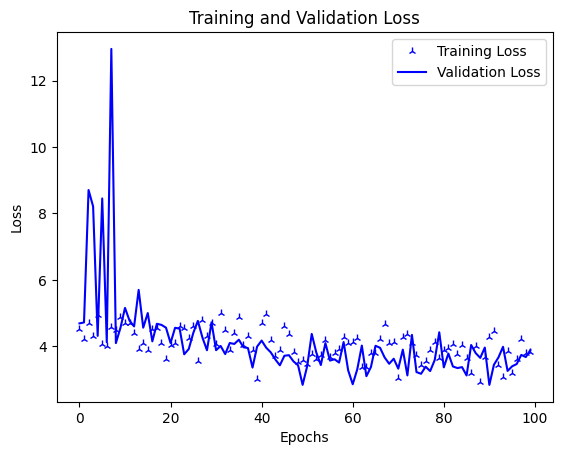

In [20]:
plt.plot(epochs_range, loss, 'b2', label='Training Loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig(result_dir + 'b2_150_epoch_loss_imagenet.png')
plt.savefig(result_dir + 'b2_150_epoch_loss_imagenet.pdf', dpi=150)
tikzplotlib.save(result_dir + 'b2_150_epoch_loss_imagenet.tex')
plt.show()

In [21]:
def smooth_curve(points, factor=0.85):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

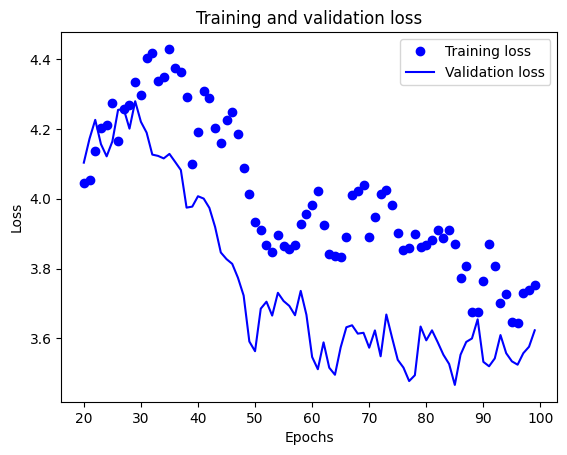

In [22]:
epochs_range = range(20,EPOCHS)
plt.plot(epochs_range,
         smooth_curve(loss[20:]), 'bo', label='Training loss')
plt.plot(epochs_range,
         smooth_curve(val_loss[20:]), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.savefig(result_dir + 'b2_150_epoch_loss_smooth_imagenet.png')
plt.savefig(result_dir + 'b2_150_epoch_loss_smooth_imagenet.pdf', dpi=150)
tikzplotlib.save(result_dir + 'b2_150_epoch_loss_smooth_imagenet.tex')

plt.show()

In [23]:
def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma, 70)
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta, 1000)
    sq2 = np.sqrt(2)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return np.mean(metric)

In [24]:
metric = []
for q in tqdm(range(1, 10)):
    m = []
    for p in vl_p:
        x = [] 
        tab = [] 
        
        if p in ['ID00011637202177653955184', 'ID00052637202186188008618']:
            continue
        for i in os.listdir(f'./Dataset/train/{p}/'):
            x.append(get_img(f'./Dataset/train/{p}/{i}')) 
            tab.append(get_tab(train.loc[train.Patient == p, :])) 
        tab = np.array(tab) 
    
        x = np.expand_dims(x, axis=-1) 
        _a = model.predict([x, tab]) 
        a = np.quantile(_a, q / 10)
        
        percent_true = train.Percent.values[train.Patient == p]
        fvc_true = train.FVC.values[train.Patient == p]
        weeks_true = train.Weeks.values[train.Patient == p]
        
        fvc = a * (weeks_true - weeks_true[0]) + fvc_true[0]
        percent = percent_true[0] - a * abs(weeks_true - weeks_true[0])
        m.append(score(fvc_true, fvc, percent))
    print(np.mean(m))
    metric.append(np.mean(m))

  0%|          | 0/9 [00:00<?, ?it/s]

8/8 [==============================] - 24s 3s/step
6.593850090242772
8/8 [==============================] - 24s 3s/step
6.605025823075059
8/8 [==============================] - 24s 3s/step
6.61598175585414
8/8 [==============================] - 24s 3s/step
6.623943156122765
7/7 [==============================] - 22s 3s/step


8/8 [==============================] - 24s 3s/step
6.631488856965885
8/8 [==============================] - 24s 3s/step
6.6399832753224715
8/8 [==============================] - 24s 3s/step
6.646904528424394
8/8 [==============================] - 25s 3s/step
6.65732204466852
8/8 [==============================] - 26s 3s/step
6.672992590289119


In [25]:
q = (np.argmin(metric) + 1)/ 2
q

0.5

In [26]:
sub = pd.read_csv('./Dataset/sample_submission.csv') 
sub.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371_-12,2000,100
3,ID00423637202312137826377_-12,2000,100
4,ID00426637202313170790466_-12,2000,100


In [27]:
test = pd.read_csv('./Dataset/test.csv') 
test

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [28]:
A_test, B_test, P_test, W, FVC, STD, WEEK = {},{},{},{},{},{},{} 

for p in test.Patient.unique():
    x = [] 
    tab = [] 
    for i in os.listdir(f'./Dataset/test/{p}/'):
        x.append(get_img(f'./Dataset/test/{p}/{i}')) 
        tab.append(get_tab(test.loc[test.Patient == p, :])) 
    tab = np.array(tab) 
            
    x = np.expand_dims(x, axis=-1) 
    _a = model.predict([x, tab]) 
    a = np.quantile(_a, q)
    A_test[p] = a
    B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p]
    P_test[p] = test.Percent.values[test.Patient == p] 
    WEEK[p] = test.Weeks.values[test.Patient == p]

13/13 [==============================] - 41s 3s/step


In [29]:
for k in sub.Patient_Week.values:
    p, w = k.split('_')
    w = int(w) 
    
    fvc = A_test[p] * w + B_test[p]
    sub.loc[sub.Patient_Week == k, 'FVC'] = fvc
    sub.loc[sub.Patient_Week == k, 'Confidence'] = (
        P_test[p] - A_test[p] * abs(WEEK[p] - w) 
) 

In [30]:
sub.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3060.056740,110.243595
1,ID00421637202311550012437_-12,2763.717205,106.762496
2,ID00422637202311677017371_-12,2016.550980,163.223473
3,ID00423637202312137826377_-12,3551.783626,337.042528
4,ID00426637202313170790466_-12,2957.660103,104.485071


In [31]:
sub[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index=False)

In [32]:
ROOT = "./Dataset/"
BATCH_SIZE=128

tr = pd.read_csv(f"{ROOT}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")

print("add infos")
sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

add infos


In [33]:
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])

In [34]:
print(tr.shape, chunk.shape, sub.shape, data.shape)
print(tr.Patient.nunique(), chunk.Patient.nunique(), sub.Patient.nunique(), 
      data.Patient.nunique())

(1535, 8) (5, 8) (730, 10) (2270, 10)
176 5 5 176


In [35]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [36]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [37]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [38]:
COLS = ['Sex','SmokingStatus'] #,'Age'
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)

In [39]:
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE += ['age','percent','week','BASE']

In [40]:
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [41]:
tr.shape, chunk.shape, sub.shape

((1535, 22), (5, 22), (730, 22))

In [78]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)

def qloss(y_true, y_pred):
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)

def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

def laplace_log_likelihood(actual_fvc, predicted_fvc, confidence, return_values = False):
    """
    Calculates the modified Laplace Log Likelihood score for this competition.
    """
    sd_clipped = np.maximum(confidence, 70)
    delta = np.minimum(np.abs(actual_fvc - predicted_fvc), 1000)
    metric = - np.sqrt(2) * delta / sd_clipped - np.log(np.sqrt(2) * sd_clipped)

    if return_values:
        return metric
    else:
        return np.mean(metric)

def make_model(nh):
    z = L.Input((nh,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    #model.compile(loss=qloss, optimizer="adam", metrics=[score])
    model.compile(loss=mloss(0.8), optimizer=tf.keras.optimizers.legacy.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model

In [79]:
## GET TRAINING DATA AND TARGET VALUE

# get target value
y  = tr['FVC'].values

# get training & test data
X_train = tr[FE].values
X_test = sub[FE].values


nh = X_train.shape[1]

# instantiate target arrays
train_preds = np.zeros((X_train.shape[0], 3))
test_preds = np.zeros((X_test.shape[0], 3))

In [80]:
net = make_model(nh)
print(net.summary())
print(net.count_params())

Model: "CNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Patient (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 d1 (Dense)                     (None, 100)          1000        ['Patient[0][0]']                
                                                                                                  
 d2 (Dense)                     (None, 100)          10100       ['d1[0][0]']                     
                                                                                                  
 p1 (Dense)                     (None, 3)            303         ['d2[0][0]']                     
                                                                                                

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [81]:
y = y.astype(np.float32)

In [82]:
y

array([2315., 2214., 2061., ..., 2908., 2975., 2774.], dtype=float32)

In [83]:
model_cnt = 1
# instantiate target arrays
globals()['train_preds_{}'.format(model_cnt)] = np.zeros((X_train.shape[0], 3))
globals()['test_preds_{}'.format(model_cnt)] = np.zeros((X_test.shape[0], 3))

NFOLD = 5
gkf = GroupKFold(n_splits=NFOLD)
groups = tr['Patient'].values

cnt = 0
EPOCHS = 800
BATCH_SIZE=128

for tr_idx, val_idx in gkf.split(X_train,y, groups):
    cnt += 1
    print(f"FOLD {cnt}")
    net = make_model(nh)
    net.fit(X_train[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS,validation_data=(X_train[val_idx], y[val_idx]), verbose=0) #
    print("train", net.evaluate(X_train[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
    print("val", net.evaluate(X_train[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))
        #print("predict val...")
    globals()['train_preds_{}'.format(model_cnt)][val_idx] = net.predict(X_train[val_idx], batch_size=BATCH_SIZE, verbose=0)
    print("predict test...")
    globals()['test_preds_{}'.format(model_cnt)] += net.predict(X_test, batch_size=BATCH_SIZE, verbose=0) / NFOLD

FOLD 1


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


train [41.447532653808594, 6.526319980621338]
val [40.68790817260742, 6.56078577041626]
predict test...
FOLD 2
train [35.79408264160156, 6.388175010681152]
val [54.13749694824219, 6.827610492706299]
predict test...
FOLD 3
train [41.74661636352539, 6.551285743713379]
val [46.75625228881836, 6.723649501800537]
predict test...
FOLD 4
train [41.226497650146484, 6.53997278213501]
val [45.54301452636719, 6.589865207672119]
predict test...
FOLD 5
train [41.479637145996094, 6.5463151931762695]
val [44.874046325683594, 6.6525702476501465]
predict test...


In [84]:
predicted_fvc = globals()['train_preds_{}'.format(model_cnt)][:,1]
confidence = globals()['train_preds_{}'.format(model_cnt)][:,2]-globals()['train_preds_{}'.format(model_cnt)][:,0]
model_score = laplace_log_likelihood(actual_fvc = y, predicted_fvc = predicted_fvc, confidence = confidence,
                       return_values = False)
print('Overall Score: ', model_score)

Overall Score:  -6.646869305988074
